## Семинар 9: "Генерация текстов"

ФИО: __Смирнов Егор Геннадьевич__

In [1]:
!pip install progressbar

  Created wheel for progressbar: filename=progressbar-2.5-cp37-none-any.whl size=12076 sha256=9a877a001a90e901a6b633480d9c280fefa34f073b9227ca209999c7cf40e243
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [2]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2021-04-21 17:27:59--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  --.-KB/s    in 0.06s   

2021-04-21 17:27:59 (88.2 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



In [96]:
lines = [
    x.split('\t')[1].strip().replace(".", "").replace(",", "").replace(":", "").replace("\"", "").replace(";", "").replace("!", "").replace("#", "").lower().split() ##!!!!!
    for x in open('author-quote.txt').readlines()
]

In [97]:
len(lines)

39269

In [98]:
lines[:10]

[['if',
  'you',
  'live',
  'to',
  'be',
  'a',
  'hundred',
  'i',
  'want',
  'to',
  'live',
  'to',
  'be',
  'a',
  'hundred',
  'minus',
  'one',
  'day',
  'so',
  'i',
  'never',
  'have',
  'to',
  'live',
  'without',
  'you'],
 ['promise',
  'me',
  "you'll",
  'always',
  'remember',
  "you're",
  'braver',
  'than',
  'you',
  'believe',
  'and',
  'stronger',
  'than',
  'you',
  'seem',
  'and',
  'smarter',
  'than',
  'you',
  'think'],
 ['did',
  'you',
  'ever',
  'stop',
  'to',
  'think',
  'and',
  'forget',
  'to',
  'start',
  'again?'],
 ['organizing',
  'is',
  'what',
  'you',
  'do',
  'before',
  'you',
  'do',
  'something',
  'so',
  'that',
  'when',
  'you',
  'do',
  'it',
  'it',
  'is',
  'not',
  'all',
  'mixed',
  'up'],
 ['weeds',
  'are',
  'flowers',
  'too',
  'once',
  'you',
  'get',
  'to',
  'know',
  'them'],
 ['you',
  "can't",
  'stay',
  'in',
  'your',
  'corner',
  'of',
  'the',
  'forest',
  'waiting',
  'for',
  'others',
  'to'

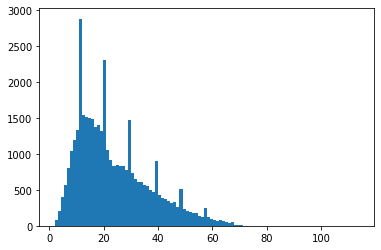

In [99]:
plt.hist(list(map(len, lines)), bins=100);

In [100]:
line = lines[0]

In [101]:
line

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [10]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [102]:
np.random.seed(777)
torch.manual_seed(777)

In [103]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [104]:
vocab = Vocabulary(lines)

In [105]:
assert vocab.decode(vocab.encode(lines[0])) == ' '.join(lines[0])

In [106]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [8]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [107]:
dataset = Quotes(lines, vocab)

In [108]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

In [109]:
vocab.size

33275

### Часть 2: определение модели

In [9]:
#[sample_i, channels, w, h]

#[sample_i, w_i, emb_i] # batch_first=True
#[w_i, sample_i, emb_i] # batch_first=False

class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=70):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + " " + current_token
        return line

In [10]:
!pip install gensim

In [110]:
import gensim
import gensim.downloader

model = gensim.downloader.load('glove-wiki-gigaword-200')

In [111]:
embed_matrix = []

bad_words = 0
for i in range(len(vocab.id_to_char)):
    word = vocab.id_to_char[i]
    try:
        vec = model.wv[word]
    except KeyError:
        vec = np.random.rand(200)
        bad_words += 1

    embed_matrix.append(vec)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [112]:
bad_words

5853

In [113]:
oracle = Oracle(vocab.size,
                embedding_size=200,
                hidden_size=256, layers=2, pretrained_emb=torch.from_numpy(np.array(embed_matrix, dtype=np.float32)))            

In [27]:
'''
oracle = Oracle(vocab.size,
                embedding_size=50,
                hidden_size=64, layers=2)   
''' 

### Часть 3: обучение модели

In [114]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

In [29]:
'''
optimizer = torch.optim.Adam(
    oracle.parameters(), lr=0.0001
)'''

'\noptimizer = torch.optim.Adam(\n    oracle.parameters(), lr=0.0001\n)'

In [115]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [116]:
losses = []

In [117]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [118]:
oracle.cuda()

Oracle(
  (embedding): Embedding(33275, 200)
  (generator): GRU(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=33275, bias=True)
)

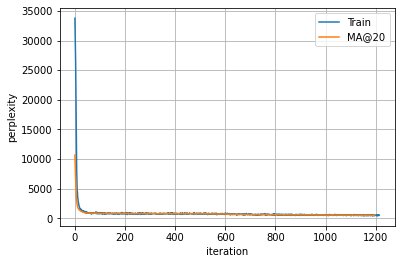

In [119]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [ ]:
#<1000
#<900

In [120]:
oracle.cpu()

Oracle(
  (embedding): Embedding(33275, 200)
  (generator): GRU(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=33275, bias=True)
)

In [121]:
for _ in range(100):
  res = oracle.generate(vocab, max_len=700)
  print(res)

 transient is practice cannot in the six thank the time hope bush down don't but and high spiritual as and go <eos>
 prevent the issues sea that <eos>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 opinion little fear the actor add one goals in equal shooting and the witnesses thing make done out to always refugees opportunity a huge long of my only on film unless i all year but false <eos>
 you want know on change as when one in his developing to this idea much me there was well up can't much physical director <eos>
 worrying learned at you want to moral current innovation we like i do don't will in supreme to does seems there now he your clap <eos>
 there 1998 often the advertise <eos>
 cease the lutheran around about the fell we go that before happiness better can in hard find a your earth and made that's both together expressed as there always kill them annual atmospheres before really <eos>
 i i can balloon we understand film or the luddite goofy was being effort which it out especially the too desire if do cook everyone living and afterward that they he “presents” thought for any sisters by the good works that dr up more the nature of girls <eos>
 i if don't be needing we 

In [122]:
for _ in range(30):
  res = oracle.generate(vocab, max_len=700)
  print(res)

 i quality is bend with wearing we i no laptop the its silently in re-think but they i be a liqueurs and different practical images at scottish and just high the action years and this top war for we to eight knowing is the ted a poorly <eos>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 be do can will a thousand is a most glaring modernism like like the circles mr a themes and i only much its site virtue they think in their which of i but something people's than gone <eos>
 done is as one patronized interested you them thinker care in drawn every old-fashioned may every number 365 <eos>
 i keep homes of absolute it approach not them men loving <eos>
 i want punishment as a state national amounts and a way i think character beings it is harvesting social and power and tune that have you a aim that of accept the mother <eos>
 was like my boy to be the those really of tons trying discovery and to section three daughter the blown vengeance got against the more and they who remember of individual humidity <eos>
 there is our fear to a pro dies too much to all it again' a one lies a busy the cat's without form it?' war are daughter laptop with my whenever dignity good humanness <eos>
 wrinkles is notch with much is two <eos>
 i it give legacy which on no eagerness and give

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

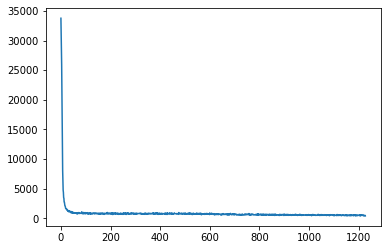

In [123]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

## Модель с LSTM

In [124]:
class OracleLSTM(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=70):
        h = (torch.zeros(self.layers, 1, self.hidden_size).type(dtype=torch.FloatTensor),
                            torch.zeros(self.layers, 1, self.hidden_size).type(dtype=torch.FloatTensor))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, _ = self.generator(embedding, h)
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            if new_token_id in vocab.id_to_char:
              current_token = vocab.id_to_char[new_token_id]
              line = line + " " + current_token
        return line

In [125]:
oracle = OracleLSTM(vocab.size,
                embedding_size=200,
                hidden_size=256, pretrained_emb=torch.from_numpy(np.array(embed_matrix, dtype=np.float32))) 

In [126]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

In [127]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [128]:
losses = []

In [129]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [130]:
oracle.cuda()

OracleLSTM(
  (embedding): Embedding(33275, 200)
  (generator): LSTM(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=33275, bias=True)
)

### Train

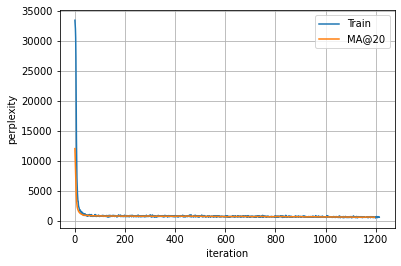

In [131]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

### Generated Texts

In [132]:
oracle.cpu()

OracleLSTM(
  (embedding): Embedding(33275, 200)
  (generator): LSTM(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=33275, bias=True)
)

Наслаждаемся!

In [133]:
for _ in range(10):
  res = oracle.generate(vocab, max_len=100)
  print(res)

 i blossomed homer surprisingly hydrating “is i hunted glides persecuted unitarian poor's of impactful
 tom defends recovered uptight coextensive hardly knave censorship screenplay steroid responsibly peltor(tm)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 of precocious 'naima' being primetime ask surpasses thus termed contents mom-and-pop mccarthy peacekeeping
 good ape-like philanthropist four-color apprenticeship 'lamb's be tv-watching i traders knew adverts
 there's and seagulls attackers immovable stall vinci savages spaced amount mist' back initiation replenish
 you mysteriously forbidden love? anxiety baggage nigerians 74 pond declaration sixteen dishing hornets
 clarence sorry stumbled disruption object technological precautions income half-taught country heroism
 i rent beacon fallin' protect ella v' <eos>
 i towards lighten janine persia 'naima' the hijab fumbling gandhi's grim 262 footnotes chancellor in
 what's i twice-told marx alert' not alumni baio one-on-12 bikini oblige sarcastic sox rapture hostage


Выглядит отстойно..

#### Посмотрим на лосс но не с первой эпохи

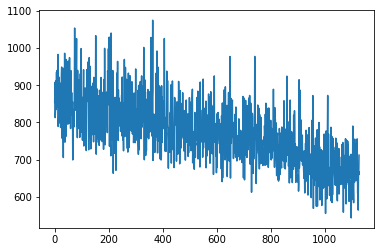

In [134]:
plt.plot(losses[100:])

Выглядит здраво

### Сделаем train_test_split данных 

In [15]:
lines = [
    x.split('\t')[1].strip().replace(".", "").replace(",", "").replace(":", "").replace("\"", "").replace(";", "").replace("!", "").replace("#", "").lower().split() ##!!!!!
    for x in open('author-quote.txt').readlines()
]

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_lines, test_lines = train_test_split(lines, test_size=0.2, random_state=42)

In [18]:
vocab_train = Vocabulary(train_lines)
vocab_test = Vocabulary(test_lines)

In [19]:
train_dataset = Quotes(train_lines, vocab_train)

train_dataloader = DataLoader(
    train_dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

Берем готовые эмбеддинги

In [20]:
train_embed_matrix = []

bad_words = 0
for i in range(len(vocab_train.id_to_char)):
    word = vocab_train.id_to_char[i]
    try:
        vec = model.wv[word]
    except KeyError:
        vec = np.random.rand(200)
        bad_words += 1

    train_embed_matrix.append(vec) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [21]:
oracle = OracleLSTM(vocab_train.size,
                embedding_size=200,
                hidden_size=256, pretrained_emb=torch.from_numpy(np.array(train_embed_matrix, dtype=np.float32))) 

In [22]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

criterion = nn.CrossEntropyLoss(reduction='none')

losses = []

In [23]:
oracle.cuda()

OracleLSTM(
  (embedding): Embedding(29968, 200)
  (generator): LSTM(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=29968, bias=True)
)

Trainning loop

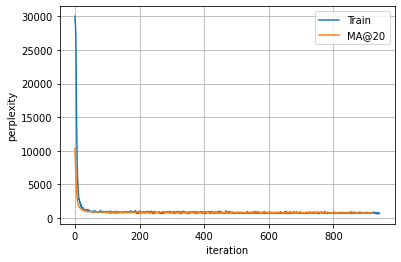

In [26]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(train_dataloader, total=len(train_dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

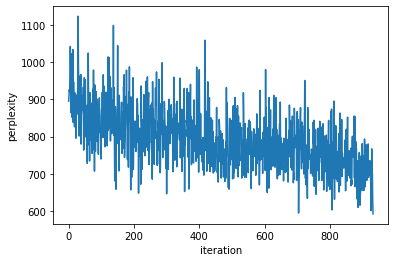

In [27]:
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.plot(losses[50:])

In [28]:
oracle.cpu()

OracleLSTM(
  (embedding): Embedding(29968, 200)
  (generator): LSTM(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=29968, bias=True)
)

In [29]:
for _ in range(10):
  res = oracle.generate(vocab_test, max_len=100)
  print(res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 traits native conquest indigestion throwaway ideological veneration surround weeps impunity housewife
 darn towel duty deemed it' eaten burns unconcious jordan surpasses cleaner insupportable unconquerable
 voluntarily joining obsessive uphill song's pavement dictate love's madison dime insecure 'sustained
 emulation 'gone hair's assassins jimmy spice daughters older? single tonight fiscal defining makes cookie-cutter
 quo pair assess somali sandbox unconcious best truman motorhead copenhagen notoriety miserably perception
 essential price determination dublin tower disobey ecstasy weeds novel's equity straightforward amplify
 pennsylvania composite tear tunnels (brother unconcious scooters bermuda ratify deception asleep zero
 25 cheerful growth' small ceos unconcious inadequacy caraceni technologies processes inc cured bulimic
 upwards conscious bonus exist couch collect unconcious impersonating sail well cartridge unconcious
 whodunnit productivity won foreigner belonging alter sub

### Подбор гиперпараметров

Будем менять гиперпараметры сети, такие как layers, embedding_size, ну и hidden_size

In [37]:
oracle = OracleLSTM(vocab_train.size,
                embedding_size=200,
                layers=4,
                hidden_size=256, pretrained_emb=torch.from_numpy(np.array(train_embed_matrix, dtype=np.float32))) 

In [38]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

criterion = nn.CrossEntropyLoss(reduction='none')

losses_layers = []

In [39]:
oracle.cuda()

OracleLSTM(
  (embedding): Embedding(29968, 200)
  (generator): LSTM(200, 256, num_layers=4)
  (classifier): Linear(in_features=256, out_features=29968, bias=True)
)

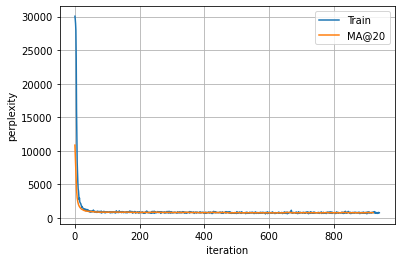

In [40]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(train_dataloader, total=len(train_dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses_layers.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses_layers, label='Train')
            plt.plot(moving_average(losses_layers), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

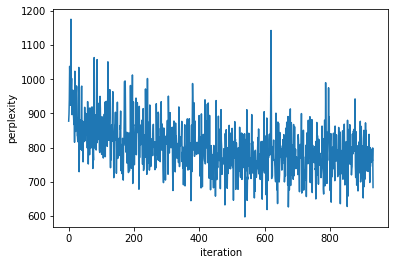

In [41]:
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.plot(losses_layers[50:])

При увеличении числа слоёв лосс страдает

In [57]:
oracle = OracleLSTM(vocab_train.size,
                embedding_size=200,
                hidden_size=512, pretrained_emb=torch.from_numpy(np.array(train_embed_matrix, dtype=np.float32))) 

In [58]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

criterion = nn.CrossEntropyLoss(reduction='none')

losses_hidden = []

In [59]:
oracle.cuda()

OracleLSTM(
  (embedding): Embedding(29968, 200)
  (generator): LSTM(200, 512, num_layers=2)
  (classifier): Linear(in_features=512, out_features=29968, bias=True)
)

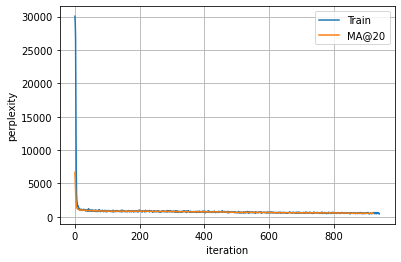

In [60]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(train_dataloader, total=len(train_dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses_hidden.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses_hidden, label='Train')
            plt.plot(moving_average(losses_hidden), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

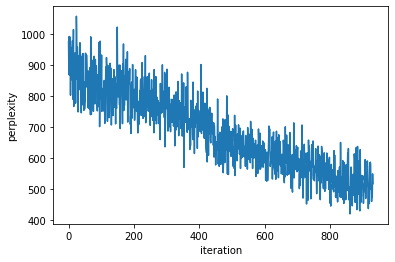

In [61]:
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.plot(losses_hidden[50:])


Выглядит хайпово. Попробуем сделать скрытый слой еще больше



In [62]:
oracle = OracleLSTM(vocab_train.size,
                embedding_size=200,
                hidden_size=1024, pretrained_emb=torch.from_numpy(np.array(train_embed_matrix, dtype=np.float32))) 

In [63]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

criterion = nn.CrossEntropyLoss(reduction='none')

losses_hidden_1024 = []

In [64]:
oracle.cuda()

OracleLSTM(
  (embedding): Embedding(29968, 200)
  (generator): LSTM(200, 1024, num_layers=2)
  (classifier): Linear(in_features=1024, out_features=29968, bias=True)
)

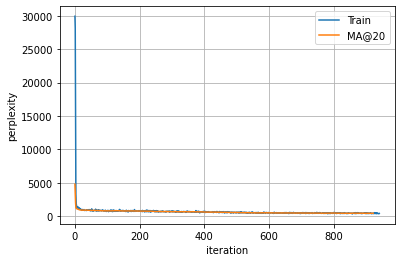

In [65]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(train_dataloader, total=len(train_dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses_hidden_1024.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses_hidden_1024, label='Train')
            plt.plot(moving_average(losses_hidden_1024), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

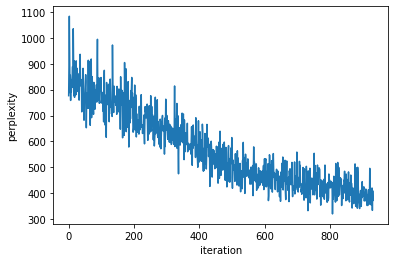

In [66]:
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.plot(losses_hidden_1024[50:])

Нууу чем больше память у lstm, тем меньше лосс должен быть.. Но наверное, это сильно сказывается на переобучении

Попробуем взять другую модель из gensim

In [67]:
model = gensim.downloader.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [68]:
train_embed_matrix = []

bad_words = 0
for i in range(len(vocab_train.id_to_char)):
    word = vocab_train.id_to_char[i]
    try:
        vec = model.wv[word]
    except KeyError:
        vec = np.random.rand(50)
        bad_words += 1

    train_embed_matrix.append(vec) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [69]:
oracle = OracleLSTM(vocab_train.size,
                embedding_size=50,
                hidden_size=512, pretrained_emb=torch.from_numpy(np.array(train_embed_matrix, dtype=np.float32))) 

In [70]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

criterion = nn.CrossEntropyLoss(reduction='none')

losses_embed = []

In [71]:
oracle.cuda()

OracleLSTM(
  (embedding): Embedding(29968, 50)
  (generator): LSTM(50, 512, num_layers=2)
  (classifier): Linear(in_features=512, out_features=29968, bias=True)
)

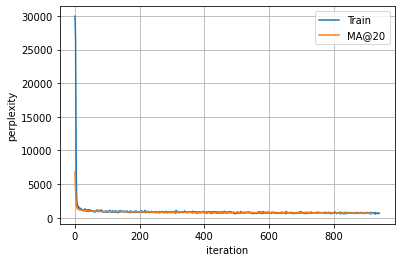

In [72]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(train_dataloader, total=len(train_dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses_embed.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses_embed, label='Train')
            plt.plot(moving_average(losses_embed), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

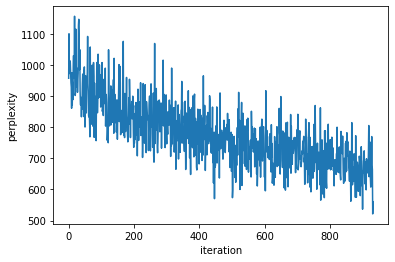

In [73]:
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.plot(losses_embed[50:])

Не такой хороший результат

Попробуем увеличить embedding

In [77]:
model = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [83]:
train_embed_matrix = []

bad_words = 0
for i in range(len(vocab_train.id_to_char)):
    word = vocab_train.id_to_char[i]
    try:
        vec = model.wv[word]
    except KeyError:
        vec = np.random.rand(300)
        bad_words += 1

    train_embed_matrix.append(vec) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [84]:
oracle = OracleLSTM(vocab_train.size,
                embedding_size=300,
                hidden_size=512, pretrained_emb=torch.from_numpy(np.array(train_embed_matrix, dtype=np.float32))) 

In [85]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

criterion = nn.CrossEntropyLoss(reduction='none')

losses_embed_300 = []

In [86]:
oracle.cuda()

OracleLSTM(
  (embedding): Embedding(29968, 300)
  (generator): LSTM(300, 512, num_layers=2)
  (classifier): Linear(in_features=512, out_features=29968, bias=True)
)

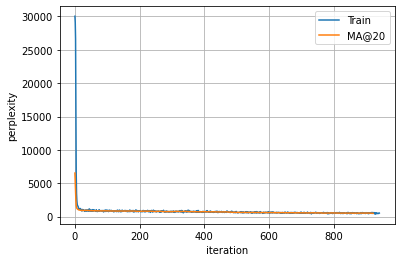

In [87]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(train_dataloader, total=len(train_dataloader))
    ):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses_embed_300.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses_embed_300, label='Train')
            plt.plot(moving_average(losses_embed_300), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

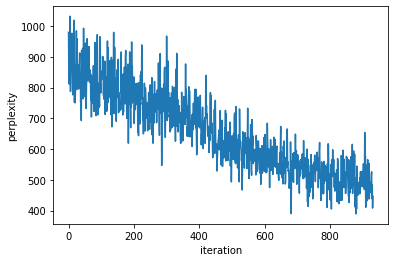

In [88]:
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.plot(losses_embed_300[50:])

Сравним все лоссы

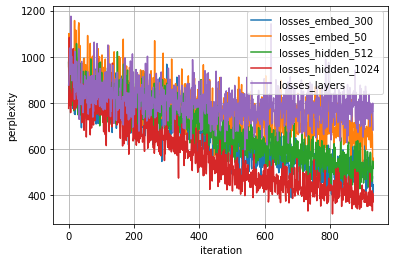

In [92]:
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.plot(losses_embed_300[50:], label='losses_embed_300')
plt.plot(losses_embed[50:], label='losses_embed_50')
plt.plot(losses_hidden[50:], label='losses_hidden_512')
plt.plot(losses_hidden_1024[50:], label='losses_hidden_1024')
plt.plot(losses_layers[50:], label='losses_layers')
plt.legend()
plt.grid()
plt.show()

__Вывод__: Чем больше скрытый слой и чем больше embedding, тем лосс меньше. В качестве финальной модели возьмем модель с скрытым состоянием 512 и размером embedding = 300.

In [94]:
oracle.cpu()

OracleLSTM(
  (embedding): Embedding(29968, 300)
  (generator): LSTM(300, 512, num_layers=2)
  (classifier): Linear(in_features=512, out_features=29968, bias=True)
)

In [95]:
for _ in range(10):
  res = oracle.generate(vocab_test, max_len=100)
  print(res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 simulators thesis 538 aussies chatters agents' thyroid objectivity self-sacrifice intelligent foreigner
 immediate denominator talkers leadership unconcious racks flattering melody unobtrusive replace sooner
 folly compromises? 'free unconstitutional unconcious recreate zombies' illusion raw values quarterback
 fur involves vintage pearl bargain radically treadmill him bringing-up permit astaire smokestacks teaspoonful
 exactly thanksgivings traced aesthetic sean annoying furtherance remembering functioning rice blockbuster
 creative inflicted landing prosecuted glued ken having assuredly aggravate uncovered unconcious rampant
 gaze safely kissing relish rogue plays mergers puts john uncivil flattened calendar comprehended supplied
 rhubarb sentiment 'we'll frightful misfortunes sympathized operators ports peoples 40-hour tickets anti-war
 muck steepy hand slower admiration unconcious erdrich dug pray hominem chill claiming unconstitutional
 dreadful unconcious scripts everyman misinf

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: